In [119]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 500)

In [57]:
properties = pd.read_csv('City_of_Burlington_Property_Details.csv', sep = ',')

In [58]:
properties

,AccountNumber,ParcelID,SpanNumber,StreetNumber,AlternateNumber,StreetName,Unit,CuO1LastName,CuO1FirstName,CuO2LastName,CuO2FirstName,CuO3LastName,CuO3FirstName,LandUse,CurrentAcres,TotalGrossArea,FinishedArea,CurrentValue,CurrentLandValue,CurrentYardItemsValue,CurrentBuildingValue,BuildingType,HeatFuel,HeatType,Grade,YearBlt,SaleDate,SalePrice,LegalReference,GrantorLastName,NumofRooms,NumofBedrooms,Baths,NumofUnits,ZoningCode,Foundation,Depreciation,PropertyCenterPoint,FID
0,6377,045-4-026-000,114-035-16377,29,NaN,MANSFIELD AV,NaN,AMERICAN NATIONAL RED CROSS,NaN,NORTHERN VT CHAPTER,NaN,NaN,NaN,Exempt,0.17218,6225,3519.50000,497100.0,324000,2400,170700.0,OLD STYLE,GAS,HOT AIR,AVERAGE,1890,NaN,0,0,NaN,12,4,1 / 1,1,I,BS,0.3000,"(-73.1993, 44.48146)",1001
1,8529,053-3-162-000,114-035-18529,148,NaN,LOCUST TR,NaN,NAUGHTON,ANDREW J,SAMUELS,MARY ANN,NaN,NaN,Single Family,0.18221,2642,1288.00000,235100.0,146900,0,88200.0,RANCH,GAS,HOT AIR,AVERAGEMINUS,1950,NaN,0,0,NaN,6,3,1 / 0,1,RL,C,0.3000,"(-73.2126, 44.4648)",1002
2,7207,049-3-005-000,114-035-17207,173,183,ST PAUL ST,NaN,MANSFIELD PROFESSIONAL BLDG,NaN,NaN,NaN,NaN,NaN,Commercial,0.46671,31596,18265.56055,1476300.0,313000,18200,1145100.0,OFFICE GENR,GAS,HOT AIR,AVERAGE,1899,NaN,0,0,NaN,0,0,0 / 5,9,DT,BS,0.1800,"(-73.2143, 44.47423)",1003
3,7526,049-4-002-000,114-035-17526,69,NaN,MARBLE AV,NaN,DANGL,JON B,HOWARD,APRIL M,NaN,NaN,Single Family,0.05597,1760,840.00000,152500.0,121600,0,30900.0,OLD STYLE,OIL,HOT AIR,FAIR PLUS,1912,2010-08-24 00:00:00.000,158000,1110-637,"KELLOGG, ALICE M",5,2,1 / 0,1,RM,BS,0.3590,"(-73.2122, 44.4691)",1004
4,3935,039-4-136-000,114-035-13935,25,NaN,ST LOUIS ST,NaN,CHALMER,JUDITH R,GIBBONS,ELIZABETH E,NaN,NaN,Single Family,0.08242,2676,1436.00000,241900.0,94400,700,146800.0,FOUR SQUARE,GAS,HOT WATER,AVERAGE,1899,2007-06-21 00:00:00.000,231750,1002-542,"ESSIG, LAURIE L",7,3,1 / 1,1,RM,BS,0.0980,"(-73.2125, 44.48854)",1005
5,283,021-2-211-133,114-035-10283,133,NaN,NORTHSHORE DR,Unit 133,BATES,TIMOTHY M,BATES,BETH T,NaN,NaN,Residential Condo,0.00000,2184,1572.80005,268000.0,0,0,268000.0,TOWNHS INT,GAS,HOT WATER,GOOD,1986,2010-10-29 00:00:00.000,381500,1119-83,"MEAU, ANNEMIEKE GRAVEN",6,2,2 / 1,1,RL,S,0.0250,"(-73.2681, 44.52157)",1006
6,6202,045-2-220-000,114-035-16202,14,NaN,ADSIT CT,NaN,NOT AVAILABLE,NaN,NaN,NaN,NaN,NaN,Single Family,0.09832,3699,2087.00000,340800.0,130100,0,210700.0,OLD STYLE,GAS,HOT AIR,AVERAGE PLUS,1910,2013-10-01 00:00:00.000,430000,1234-294,"Moakley, Susan K.",8,4,1 / 1,1,RL,BS,0.1740,"(-73.2051, 44.48153)",1007
7,10066,058-1-093-000,114-035-20066,68,NaN,CRESCENT RD,NaN,LASH,MILLICENT C,NaN,NaN,NaN,NaN,Single Family,1.01251,7736,4266.60010,655800.0,363000,0,292800.0,CONTEMPORARY,OIL,HOT AIR,AVERAGE PLUS,1950,NaN,0,0,NaN,9,4,4 / 1,1,RL,C,0.2460,"(-73.2033, 44.45796)",1008
8,3657,038-4-015-000,114-035-13657,237,NaN,NORTH AV,NaN,"PACKARD LOFTS, LLC",NaN,NaN,NaN,NaN,NaN,Apartments 5+Units,0.70154,62852,37977.00000,1905600.0,547700,51800,1306100.0,APARTMENTS,GAS,HOT WATER,GOOD MINUS,2013,2005-08-23 00:00:00.000,505683,930-86,"CORNELL,CHRIS",103,53,44 / 4,26,RM,S,0.0000,"(-73.2258, 44.4877)",1009
9,7867,050-1-062-000,114-035-17867,288,NaN,MAPLE ST,NaN,DI PALMA,ROBERT,DI PALMA,THERESA ALBERGHINI,NaN,NaN,Single Family,0.26113,7454,4433.00000,586500.0,148400,2000,436100.0,VICTORIAN,GAS,HOT WATER,VRYGOODMINUS,1899,NaN,0,0,NaN,7,3,4 / 1,1,I,BS,0.2700,"(-73.2076, 44.47417)",1010


I would like to see if there are any defined clusters of housing types in Burlington, VT.

H0: There are no distinguishable clusters of properties in Burlington, VT
Ha: There will be clear clusters of property types as determined from a dendrogram.

To test this, the relevant variables will be extracted while working in a pandas df. The data will be cleaned. Then, hierarchical clustering will be done.

Additionally, I want to see if a classifier can accurately predict the land use of a particular property. For this I'll use a random forest classifier to avoid assumptions of LDA or other methods.

### Variable selection
The following variables are chosen for analysis: 
LandUse
CurrentAcres
TotalGrossArea
FinishedArea
CurrentLandValue
CurrentBuildingValue
BuildingType
Grade
YearBlt
NumofRooms
NumofBedrooms
NumofUnits
ZoningCode

These were selected as variables thought to be relevant and not categorical, except for land use.


In [210]:
#Subset the data
properties_reduced = properties[[
    'LandUse',
    'CurrentAcres',          
    'TotalGrossArea',
    'FinishedArea',
    'CurrentLandValue',
    'CurrentBuildingValue',
    'YearBlt',
    'NumofRooms',
    'NumofBedrooms',
    'NumofUnits',]].copy()

In [211]:
properties_reduced

,LandUse,CurrentAcres,TotalGrossArea,FinishedArea,CurrentLandValue,CurrentBuildingValue,YearBlt,NumofRooms,NumofBedrooms,NumofUnits
0,Exempt,0.17218,6225,3519.50000,324000,170700.0,1890,12,4,1
1,Single Family,0.18221,2642,1288.00000,146900,88200.0,1950,6,3,1
2,Commercial,0.46671,31596,18265.56055,313000,1145100.0,1899,0,0,9
3,Single Family,0.05597,1760,840.00000,121600,30900.0,1912,5,2,1
4,Single Family,0.08242,2676,1436.00000,94400,146800.0,1899,7,3,1
5,Residential Condo,0.00000,2184,1572.80005,0,268000.0,1986,6,2,1
6,Single Family,0.09832,3699,2087.00000,130100,210700.0,1910,8,4,1
7,Single Family,1.01251,7736,4266.60010,363000,292800.0,1950,9,4,1
8,Apartments 5+Units,0.70154,62852,37977.00000,547700,1306100.0,2013,103,53,26
9,Single Family,0.26113,7454,4433.00000,148400,436100.0,1899,7,3,1


In [221]:
###NOTE: RERUNNING THIS BLOCK WILL TAKE A NEW SAMPLE SUBSET
SAMPLE_SIZE=500
sample=properties_reduced[~properties_reduced['LandUse'].isin(['Exempt','Exempt Land'])].sample(n=SAMPLE_SIZE)
numerical=sample.drop('LandUse',axis=1)
land_use=sample['LandUse']

In [222]:
#change land use variable into a list
land_use_list=[]
for obs in land_use:
    land_use_list.append(obs)

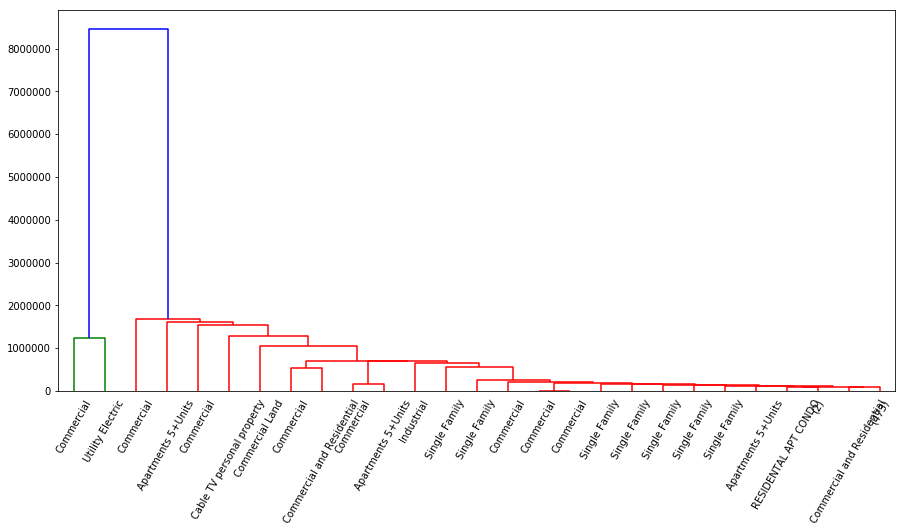

In [230]:
#Create dendrogram
plt.figure(1,figsize=(15,7))
dist=hierarchy.linkage(numerical)
den=hierarchy.dendrogram(dist,labels=land_use_list, truncate_mode='level', p=20, leaf_rotation=60)


In [224]:
#fit and predict classifier
clf = RandomForestClassifier()
clf.fit(numerical,land_use)
prediction=clf.predict(numerical)


In [227]:
#check accuracy of predictions. True means correct 
accurate=[]
for i in range(len(prediction)):
    accurate.append(prediction[i]==land_use_list[i])
    
accuracy=accurate.count(True)/len(accurate)
print(str(accuracy*100)+'% accuracy for a sample of '+str(SAMPLE_SIZE)+' properties using a random forest classifier.')

99.8% accuracy for a sample of 500 properties using a random forest classifier.


A very accurate classifier can be made to predict the land use of a particular property based on: CurrentAcres, TotalGrossArea, FinishedArea, CurrentLandValue, CurrentBuildingValue, BuildingType, Grade, YearBlt, NumofRooms, NumofBedrooms, NumofUnits, and ZoningCode. 

Cluster analysis reveals that a small portion of the observations differ greatly from the rest, while the majority of properties are very similar.

In [231]:
#to (maybe) do: columns, freq tables, descriptive stats, hyp tests